In [1]:
import sys
import os
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")

atlas_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/x64/Debug"
sys.path.append(atlas_path)


from AtlasPy.core import Hydra, Portfolio, Strategy
from AtlasPy.ast import *

In [2]:
exchange_path = "C:/Users/natha/OneDrive/Desktop/C++/Atlas/AtlasPy/src/exchangeVBT"
strategy_id = "test_strategy"
exchange_id = "test_exchange"
portfolio_id = "test_portfolio"

hydra = Hydra()
intial_cash = 100.0
exchange = hydra.addExchange(exchange_id, exchange_path, "%Y-%m-%d %H:%M:%S")
portfolio = hydra.addPortfolio(portfolio_id, exchange, intial_cash)
hydra.build()

In [3]:
hydra.reset()
multiplier = 3
st = time.perf_counter_ns()
close = AssetReadNode.make("Close", 0, exchange)
previous_close = AssetReadNode.make("Close", -1, exchange)

atr_node = ATRNode.make(
    exchange,
    "High",
    "Low",
    14
) 
median_node = AssetMedianNode.make(
    exchange,
    "High",
    "Low",
)

# ===== Lower Band =====
lower_band = AssetOpNode.make(
    median_node,
    AssetScalerNode(atr_node, AssetOpType.MULTIPLY, multiplier),
    AssetOpType.SUBTRACT
)
lower_left_cond = AssetIfNode(
    lower_band,
    AssetCompType.GREATER,
    DummyNode(exchange)
)
lower_right_cond = AssetIfNode(
    previous_close,
    AssetCompType.LESS, 
    DummyNode(exchange)
)
final_lower_band = AssetCompNode(
    lower_left_cond,
    LogicalType.OR,
    lower_right_cond,
    lower_band,
    DummyNode(exchange)
)
lagged_final_lower_band = final_lower_band.lag(1)
lower_left_cond.swapRightEval(lagged_final_lower_band)
lower_right_cond.swapRightEval(lagged_final_lower_band)
final_lower_band.swapFalseEval(lagged_final_lower_band)
# ======================

# ===== Upper Band =====
upper_band = AssetOpNode.make(
    median_node,
    AssetScalerNode(atr_node, AssetOpType.MULTIPLY, multiplier),
    AssetOpType.ADD
)
upper_left_cond = AssetIfNode(
    upper_band,
    AssetCompType.LESS,
    DummyNode(exchange)
)
upper_right_cond = AssetIfNode(
    previous_close,
    AssetCompType.GREATER, 
    DummyNode(exchange)
)
final_upper_band = AssetCompNode(
    upper_left_cond,
    LogicalType.OR,
    upper_right_cond,
    upper_band,
    DummyNode(exchange)
)
lagged_final_upper_band = final_upper_band.lag(1)
upper_left_cond.swapRightEval(lagged_final_upper_band)
upper_right_cond.swapRightEval(lagged_final_upper_band)
final_upper_band.swapFalseEval(lagged_final_upper_band)
# ======================

exchange.enableNodeCache("final_lower_band",final_lower_band, False)
exchange.enableNodeCache("final_upper_band",final_upper_band, False)

spread_upper = AssetOpNode.make(close, final_upper_band, AssetOpType.SUBTRACT)
spread_lower = AssetOpNode.make(close, final_lower_band, AssetOpType.SUBTRACT)
spread_filter_up = ExchangeViewFilter(ExchangeViewFilterType.GREATER_THAN, 0.0, None)
spread_filter_down = ExchangeViewFilter(ExchangeViewFilterType.LESS_THAN, 0.0, None)
exchange_view_down = ExchangeViewNode.make(exchange, spread_lower, spread_filter_down)
exchange_view_up = ExchangeViewNode.make(exchange, spread_upper, spread_filter_up, exchange_view_down)
exchange.enableNodeCache("exchange_view_up",exchange_view_up, False)
allocation_signal = AllocationNode.make(
    exchange_view_up,
    AllocationType.CONDITIONAL_SPLIT,
    0.0,
    -1
)
strategy_node_signal = StrategyNode.make(allocation_signal, portfolio)
strategy = hydra.addStrategy(Strategy(strategy_id, strategy_node_signal, 1.0), True)
strategy.enableTracerHistory(TracerType.NLV)
strategy.enableTracerHistory(TracerType.ORDERS_EAGER)
hydra.run()

et = time.perf_counter_ns()
print(f"Time to build: {(et-st)/1e6}ms")

Time to build: 154.5803ms


In [4]:
path = os.path.join(exchange_path,"BTC-USD.csv")  
df = pd.read_csv(path)
df["final_upper_band"] = final_upper_band.cache()[0]
df["final_lower_band"] = final_lower_band.cache()[0]
df["ev"] =  exchange_view_up.cache()[0]
df["spread_lower"] = df["Close"] - df["final_lower_band"]

df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)
df.index = df.index.tz_localize(None)
df.iloc[33:40]

,Open,High,Low,Close,Volume,Dividends,Stock Splits,final_upper_band,final_lower_band,ev,spread_lower
Date,,,,,,,,,,,
2018-02-03,8852.120117,9430.750000,8251.629883,9174.910156,7263790080,0.0,0.0,12022.527143,8227.939610,0.000000,946.970546
2018-02-04,9175.700195,9334.870117,8031.220215,8277.009766,7073549824,0.0,0.0,12022.527143,8227.939610,0.000000,49.070156
2018-02-05,8270.540039,8364.839844,6756.680176,6955.270020,9285289984,0.0,0.0,11227.471876,8227.939610,-1272.669591,-1272.669591
2018-02-06,7051.750000,7850.700195,6048.259766,7754.000000,13999800320,0.0,0.0,10740.521091,3158.438870,-1272.669591,4595.561130
2018-02-07,7755.490234,8509.110352,7236.790039,7621.299805,9169280000,0.0,0.0,10740.521091,4080.057668,-1272.669591,3541.242136
2018-02-08,7637.859863,8558.769531,7637.859863,8265.589844,9346750464,0.0,0.0,10740.521091,4375.456695,-1272.669591,3890.133149
2018-02-09,8271.839844,8736.980469,7884.709961,8736.980469,6784820224,0.0,0.0,10740.521091,4671.276247,-1272.669591,4065.704222


In [5]:
# get all rows where ev is not nan
x = df[df["ev"].notna()]
x

,Open,High,Low,Close,Volume,Dividends,Stock Splits,final_upper_band,final_lower_band,ev,spread_lower
Date,,,,,,,,,,,
2018-01-01,14112.200195,14112.200195,13154.700195,13657.200195,10291200000,0.0,0.0,0.000000,0.000000,0.000000,13657.200195
2018-01-02,13625.000000,15444.599609,13163.599609,14982.099609,16846600192,0.0,0.0,0.000000,0.000000,0.000000,14982.099609
2018-01-03,14978.200195,15572.799805,14844.500000,15201.000000,16871900160,0.0,0.0,0.000000,0.000000,0.000000,15201.000000
2018-01-04,15270.700195,15739.700195,14522.200195,15599.200195,21783199744,0.0,0.0,0.000000,0.000000,0.000000,15599.200195
2018-01-05,15477.200195,17705.199219,15202.799805,17429.500000,23840899072,0.0,0.0,0.000000,0.000000,0.000000,17429.500000
...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,43468.199219,43804.781250,42318.550781,42627.855469,22992093014,0.0,0.0,45400.693289,40304.667242,720.217859,2323.188227
2023-12-29,42614.644531,43124.324219,41424.062500,42099.402344,26000021055,0.0,0.0,45400.693289,40304.667242,720.217859,1794.735102
2023-12-30,42091.753906,42584.125000,41556.226562,42156.902344,16013925945,0.0,0.0,45400.693289,40304.667242,720.217859,1852.235102


In [6]:
orders = strategy.getTracer().getOrders()
orders = [o.to_dict() for o in orders]
df_orders = pd.DataFrame(orders)
df_orders["fill_time"] = pd.to_datetime(df_orders["fill_time"])
df_orders.set_index("fill_time", inplace=True)
df_orders.head(10)

,asset_id,strategy_id,quantity,fill_price
fill_time,,,,
2018-02-06 05:00:00,0,0,-0.011416,7754.000000
2018-02-18 05:00:00,0,0,0.010589,10551.799805
2018-03-11 05:00:00,0,0,-0.009013,9578.629883
2018-04-16 05:00:00,0,0,0.011104,8058.669922
2018-05-12 05:00:00,0,0,-0.010938,8504.889648
2018-07-08 05:00:00,0,0,0.015970,6773.879883
2018-08-05 05:00:00,0,0,-0.015809,7068.479980
2018-08-29 05:00:00,0,0,0.015390,7047.160156
2018-09-07 05:00:00,0,0,-0.015685,6467.069824


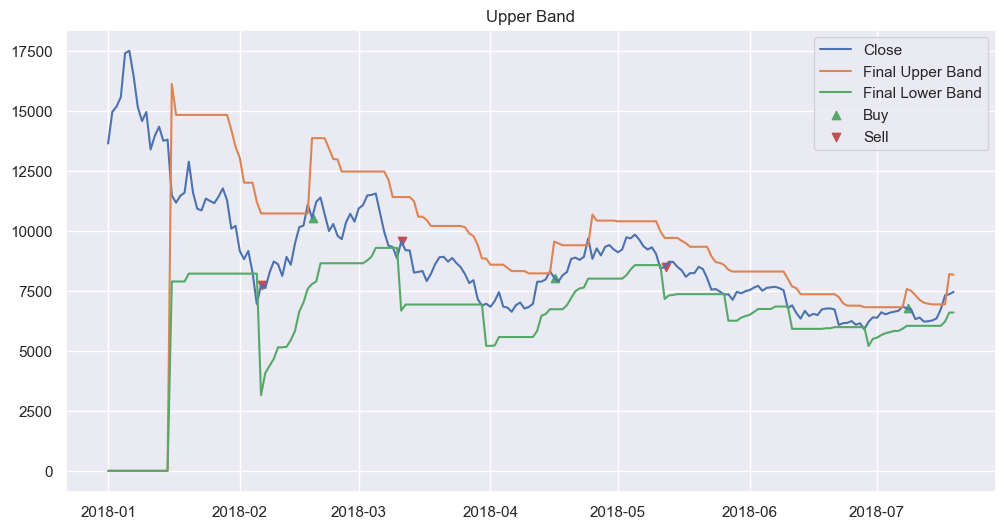

In [7]:
n = 200
df_sub = df.iloc[:n]
df_sub_max_time = df_sub.index.max()
df_orders_sub = df_orders[df_orders.index <= df_sub_max_time]

buys = df_orders_sub[df_orders_sub["quantity"] > 0]
sells = df_orders_sub[df_orders_sub["quantity"] < 0]

plt.figure(figsize=(12,6))
plt.plot(df_sub["Close"], label="Close")
plt.plot(df_sub["final_upper_band"], label="Final Upper Band")
plt.plot(df_sub["final_lower_band"], label="Final Lower Band")
plt.scatter(buys.index, buys["fill_price"], label="Buy", marker="^", color="g")
plt.scatter(sells.index, sells["fill_price"], label="Sell", marker="v", color="r")
plt.title("Upper Band")
plt.legend()
plt.show()

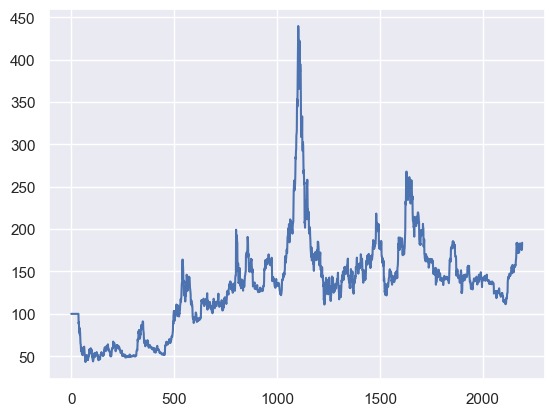

In [8]:
plt.plot(strategy.getHistory(TracerType.NLV))